In [1]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

project_folder = "example_data"


# Small subset of data from CASA simulation

dirty image :


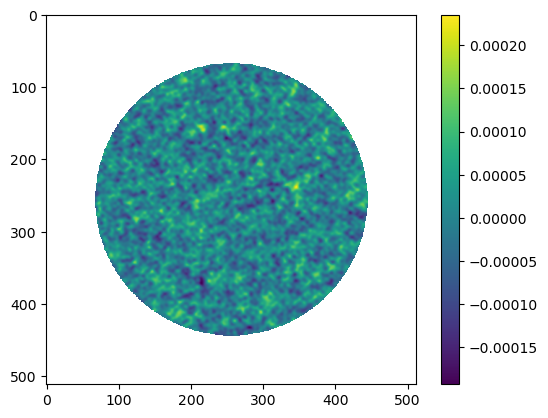

key : e0ded2a7-4a05-4138-9fe7-52706e89e313
phase_centers : {'RA': 148.3491666667, 'DEC': 2.781833333333}
dirty image :


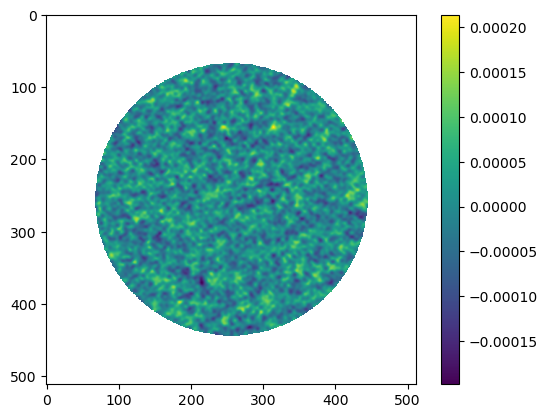

key : 37016a39-3b1d-4024-a44c-218c638cec9f
phase_centers : {'RA': 149.2431666667, 'DEC': 2.443833333333}


In [2]:
folder = "mock_real_data"
sky_keys = np.load(f"{project_folder}/{folder}/sky_keys.npy")
phase_centers = np.load(f"{project_folder}/{folder}/ra_dec.npy", allow_pickle=True).item()
for i, key in enumerate(sky_keys[:2]):
    dirty = np.load(f"{project_folder}/{folder}/dirty/{i:05}.npy")
    print("dirty image :")
    plt.imshow(dirty)
    plt.colorbar()
    plt.show()
    print(f"key : {key}")
    print(f"phase_centers : {phase_centers[key]}")

dirty image :


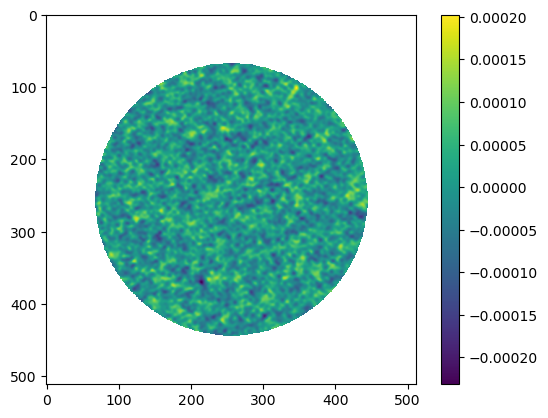

true image :


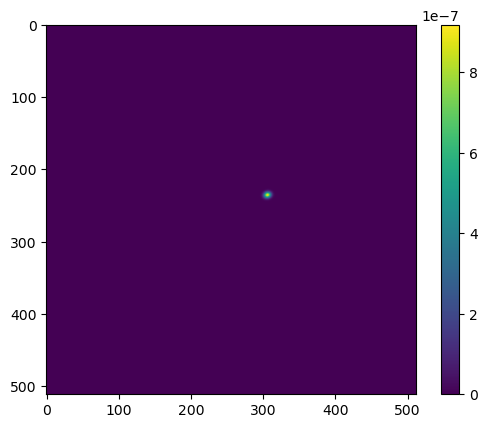

key : d585b966-ca55-4d56-9046-e647ce0160c2
phase_centers : {'RA': 150.4211666667, 'DEC': 0.5258333333333}
sources (in ra, dec) : [[150.4197777777887, 0.5252777777777786, 1.0792079207920793, 0.660220834816036, 5.396039603960396e-05, 0.6568656865686568, 0.7891189118911892]]
dirty image :


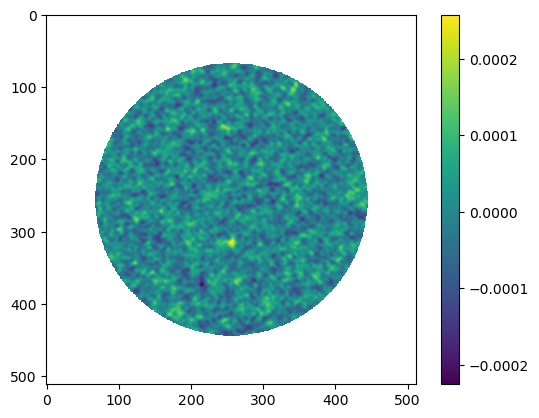

true image :


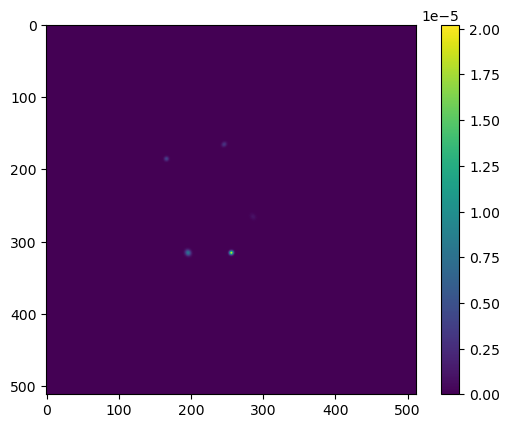

key : a54e1644-1e8d-43bd-9742-e3215ce5aa05
phase_centers : {'RA': 148.2531666667, 'DEC': 3.857833333333}
sources (in ra, dec) : [[148.2556666666671, 3.8558888888888925, 2.3249324932493254, 1.8367274640253233, 0.00011624662466246626, 0.4933693369336934, 0.49944994499449946], [148.25344444444497, 3.855333333333337, 2.081008100810081, 1.5674457753540614, 0.00010405040504050405, 0.4962896289628963, 0.5836183618361837], [148.2523333333339, 3.858111111111115, 1.0504050405040504, 0.6702020592230484, 5.2520252025202525e-05, 0.6013401340134014, 0.7681168116811681], [148.2531666666672, 3.859500000000004, 9.018001800180018, 7.521007136636812, 0.0004509000900090009, 0.4356835683568357, 0.45164516451645165], [148.2548333333338, 3.859500000000004, 7.202520252025201, 4.848479240033385, 0.0003601260126012601, 0.6016601660166017, 0.6776277627762777]]


In [3]:
folder = "mock_data"
sky_keys = np.load(f"{project_folder}/{folder}/sky_keys.npy")
sky_sources_snr_extended = np.load(f"{project_folder}/{folder}/sky_sources_snr_extended.npy", allow_pickle=True).item()    
snr = np.load(f"{project_folder}/{folder}/sky_keys.npy")
phase_centers = np.load(f"{project_folder}/{folder}/ra_dec.npy", allow_pickle=True).item()
for i, key in enumerate(sky_keys[:2]):
    dirty = np.load(f"{project_folder}/{folder}/dirty/{i:05}.npy")
    true = np.load(f"{project_folder}/{folder}/true/{i:05}.npy")
    print("dirty image :")
    plt.imshow(dirty)
    plt.colorbar()
    plt.show()
    print("true image :")
    plt.imshow(true)
    plt.colorbar()
    plt.show()
    print(f"key : {key}")
    print(f"phase_centers : {phase_centers[key]}")
    print(f"sources (in ra, dec) : {sky_sources_snr_extended[key]}")

# Simulate 

This code can be used to fast create toy data.

# Mock simulated train data

In [4]:
# Function to create a Gaussian
def add_gaussian(array, mean_x, mean_y, std_dev, max_value=1.0):
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            array[i, j] += max_value*np.exp(-((i-mean_x)**2 + (j-mean_y)**2)/(2*std_dev**2))
    return array

# Create a blank 512x512 array


# Function to generate random parameters for Gaussian
def generate_random_params():
    mean_x = np.random.randint(64, 512-64)
    mean_y = np.random.randint(64, 512-64)
    std_dev = random.uniform(0.5, 2.0)  # Chose random std_dev between 2 and 30
    max_value = random.uniform(0.5, 50)
    return mean_x, mean_y, std_dev, max_value


In [8]:
folder = "toy_data"
save_data = True

if not os.path.exists(f"{project_folder}/{folder}"):
    os.mkdir(f"{project_folder}/{folder}")
    
if not os.path.exists(f"{project_folder}/{folder}/dirty"):
    os.mkdir(f"{project_folder}/{folder}/dirty")
if not os.path.exists(f"{project_folder}/{folder}/true"):
    os.mkdir(f"{project_folder}/{folder}/true")
    
phase_centers = {}
keys_list = []
sky_sources_info = {}

noise_std = 5e-5
img_multiplier =  1e-5

for i in range(0, 10164):
    image = np.zeros((512, 512))
    
    key = f"{i:06}" #could be any unique string
    keys_list.append(key)
    sky_sources_info[key] = []
    
    #generate random RA, DEC
    ra_min = 149.43959
    ra_max = 150.756584
    
    dec_min = 1.555417
    dec_max = 2.880238
    
    ra = random.uniform(ra_min, ra_max)
    dec = random.uniform(dec_min, dec_max)
    
    phase_centers[key] = {"RA" : ra, "DEC" : dec,}
    
    # Add three Gaussians with random mean values and std_dev
    for _ in range(np.random.randint(1, 5)):
        mean_x, mean_y, std_dev, max_value = generate_random_params()
        max_value = max_value*img_multiplier
        image_before = image.copy()  # Store the image before adding the Gaussian
        image = add_gaussian(image, mean_x, mean_y, std_dev, max_value)
        
        std_dev = 0.1*2.3548*std_dev
        
        flux = np.sum(image - image_before)  # Compute flux as sum of all the pixel values in the Gaussian
        SNR = max_value/noise_std
        
        beam_maj = 0.89
        beam_min = 0.82
        s_min = std_dev
        s_max = std_dev
        SNR_normalized = SNR*(beam_maj*beam_min)/np.sqrt((beam_maj**2+s_max**2)*(beam_min**2+s_min**2))

        sky_sources_info[key].append([
            ra,
            dec,
            SNR,
            SNR_normalized,
            flux,
            std_dev,
            std_dev,
        ])

    # Scale the array so that its maximum is around 10**(-5)
    filename = f"{i:06}.npy"
    
    # Plotting the generated image
    #plt.imshow(image, cmap="gray")
    #plt.colorbar()
    #plt.show()
    if save_data:
        np.save(f"example_data/toy_data/true/{filename}", image)
    
    # Add Gaussian noise on top
    noise = np.random.normal(0, noise_std, image.shape)
    image += noise
    if save_data:
        np.save(f"example_data/toy_data/dirty/{filename}", image)
    # Plotting the generated image
    #plt.imshow(image, cmap="gray")
    #plt.colorbar()
    #plt.show()
    
if save_data:
    np.save("example_data/toy_data/ra_dec.npy", phase_centers)
    np.save("example_data/toy_data/sky_keys.npy", keys_list)
    np.save("example_data/sky_sources_snr_extended.npy", sky_sources_info)    



# Mock simulated real data

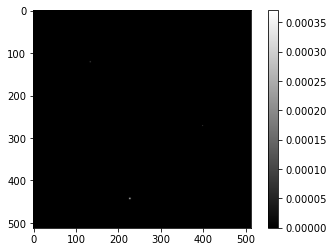

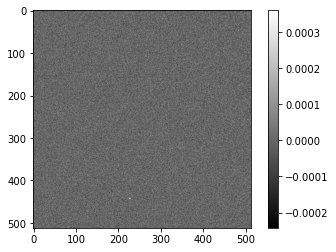

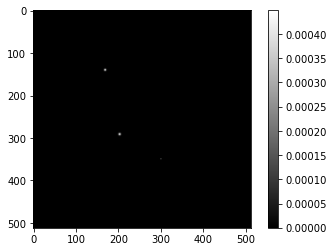

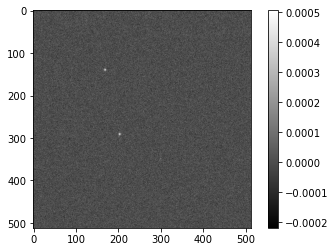

In [39]:
folder = "toy_real_data"
save_data = False

if not os.path.exists(f"{project_folder}/{folder}"):
    os.mkdir(f"{project_folder}/{folder}")
    
if not os.path.exists(f"{project_folder}/{folder}/dirty"):
    os.mkdir(f"{project_folder}/{folder}/dirty")
    
phase_centers = {}
keys_list = []
sky_sources_info = {}

noise_std = 5e-5
img_multiplier =  1e-5

for i in range(0, 2):
    image = np.zeros((512, 512))
    
    key = f"{i:06}" #could be any unique string
    keys_list.append(key)
    sky_sources_info[key] = []
    
    #generate random RA, DEC
    ra_min = 149.43959
    ra_max = 150.756584
    
    dec_min = 1.555417
    dec_max = 2.880238
    
    ra = random.uniform(ra_min, ra_max)
    dec = random.uniform(dec_min, dec_max)
    
    phase_centers[key] = {"RA" : ra, "DEC" : dec,}
    
    # Add three Gaussians with random mean values and std_dev
    for _ in range(np.random.randint(1, 5)):
        mean_x, mean_y, std_dev, max_value = generate_random_params()
        max_value = max_value*img_multiplier
        image_before = image.copy()  # Store the image before adding the Gaussian
        image = add_gaussian(image, mean_x, mean_y, std_dev, max_value)
        
        std_dev = 0.1*2.3548*std_dev
        
        flux = np.sum(image - image_before)  # Compute flux as sum of all the pixel values in the Gaussian
        SNR = max_value/noise_std
        
        beam_maj = 0.89
        beam_min = 0.82
        s_min = std_dev
        s_max = std_dev
        SNR_normalized = SNR*(beam_maj*beam_min)/np.sqrt((beam_maj**2+s_max**2)*(beam_min**2+s_min**2))

        sky_sources_info[key].append([
            ra,
            dec,
            SNR,
            SNR_normalized,
            flux,
            std_dev,
            std_dev,
        ])

    # Scale the array so that its maximum is around 10**(-5)
    filename = f"{i:06}.npy"
    
    # Plotting the generated image
    plt.imshow(image, cmap="gray")
    plt.colorbar()
    plt.show()

    # Add Gaussian noise on top
    noise = np.random.normal(0, noise_std, image.shape)
    image += noise
    
    if save_data:
        np.save(f"{project_folder}/{folder}/dirty/{filename}", image)
    # Plotting the generated image
    plt.imshow(image, cmap="gray")
    plt.colorbar()
    plt.show()
    
if save_data:  
    np.save(f"{project_folder}/{folder}/ra_dec.npy", phase_centers)
    np.save(f"{project_folder}/{folder}//sky_keys.npy", keys_list)


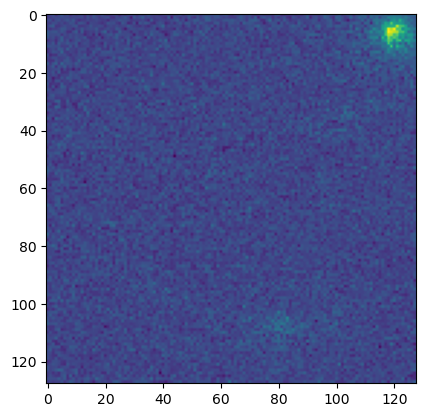

In [5]:
plt.imshow(np.load("prova_power2/batch=0_val_dirty_noisy.npy")[0])

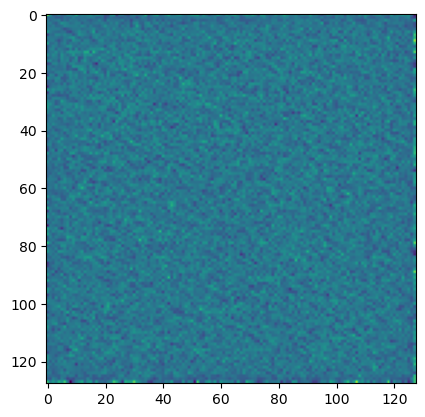

In [6]:
plt.imshow(np.load("prova_power2/batch=0_val_generated_images.npy")[0])

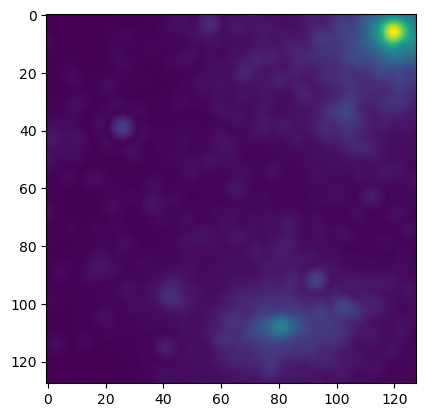

In [7]:
plt.imshow(np.load("prova_power2/batch=0_val_images.npy")[0])